# qfactor
Determine optimum distnace cut by looking at simulated data
Author: Nik Korzoun

# Imports

In [1]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# Read Data
1 corresponds to gamma-rays and 2 corresponds to cosmic-rays

e.g. df1 is the dataframe with gamma-ray data and df2 is the dataframe with cosmic-ray data

## Data files

In [2]:
# read data

df1 = pd.read_csv("data/lick2024/MRK421-sim-gamma/data/_merged.10xSig.reconstructed.csv")
df2 = pd.read_csv("data/lick2024/MRK421-sim-proton/data/_merged.10xSig.reconstructed.csv")

# df1 = pd.read_csv("../triangle_data/dev/tmp/MRK421-sim-gamma/data/_merged.csv")
# df2 = pd.read_csv("../triangle_data/dev/tmp/MRK421-sim-proton/data/_merged.csv")

# df1 = pd.read_csv("data/lick2024_layouts_test/10TeV/layout1/data/_merged.csv")
# df2 = pd.read_csv("data/lick2024_layouts_test/10TeV/layout1_PROTONS/data/_merged.csv")

# df1 = pd.read_csv("data/lick2024_layouts_test/10TeV/layout2/data/_merged.csv")
# df2 = pd.read_csv("data/lick2024_layouts_test/10TeV/layout2_PROTONS/data/_merged.csv")


## Cleaning data

In [3]:
# remove nans
array1=df1.dropna(subset=["Length", "Width","Miss","Distance","Azwidth","Alpha"])
array1=array1[array1["Width"]>0]
#array1.head()

array2=df2.dropna(subset=["Length", "Width","Miss","Distance","Azwidth","Alpha"])
array2=array2[array2["Width"]>0]
#array2.head()

# Defining Cuts

## Ntel

In [4]:
# cut by number of telescopes
NTel=2
array1 = array1.groupby('Event', group_keys=False).filter(lambda x: len(x) >= NTel)
array2 = array2.groupby('Event', group_keys=False).filter(lambda x: len(x) >= NTel)

## Max Distance

In [5]:
# create max distance parameter
max1 = array1.groupby(['Event'])['Distance'].transform('max') == array1['Distance']
max_distance1= array1.loc[max1, ['Event', 'Distance']]
array1['MaxDistance']=max_distance1.Distance
max2 = array2.groupby(['Event'])['Distance'].transform('max') == array2['Distance']
max_distance2= array2.loc[max2, ['Event', 'Distance']]
array2['MaxDistance']=max_distance2.Distance


## Theta Squared

In [6]:
def plotPSF(dataframe=df1, title="Photon Events", angle_range=(0,10), core_range=(0,200),threshold=10000):

    # energy threshold
    dataframe=dataframe[dataframe["TrueEnergy"]>threshold]

    data1 = dataframe.dropna(subset=["Az","Ze"]).drop_duplicates(subset="Event")
    c1 = SkyCoord(az=data1["Az"].values*u.deg, alt=(90-data1["Ze"].values)*u.deg, frame='altaz')
    c2 = SkyCoord(az=0*u.deg, alt=90*u.deg,frame='altaz')
    angle1=pd.DataFrame(c1.separation(c2).deg)
    core1 = pd.DataFrame(np.abs(np.hypot(data1["Xcore"].values,data1["Ycore"].values)-np.hypot(data1["TrueXcore"].values,data1["TrueYcore"].values)))

    data2 = dataframe.dropna(subset=["Az","Ze"]).dropna(subset="Alpha")
    data2 = data2.groupby('Event', group_keys=False).filter(lambda x: len(x) > 2).drop_duplicates(subset="Event") #require more than 2 telescopes
    c1 = SkyCoord(az=data2["Az"].values*u.deg, alt=(90-data2["Ze"].values)*u.deg, frame='altaz')
    c2 = SkyCoord(az=0*u.deg, alt=90*u.deg,frame='altaz')
    angle2=pd.DataFrame(c1.separation(c2).deg)
    core2 = pd.DataFrame(np.abs(np.hypot(data2["Xcore"].values,data2["Ycore"].values)-np.hypot(data2["TrueXcore"].values,data2["TrueYcore"].values)))

    fig, axs = plt.subplots(1,2, figsize=(9,5))
    fig.suptitle(title)

    axs[0].set_xlabel(r'Squared Angular Error [degrees$^2$]')
    axs[0].set_ylabel('Entries')
    axs[0].hist(angle1*angle1, alpha=0.3, bins = 50, range=angle_range,label = 'at least 2 telescopes' )
    axs[0].hist(angle2*angle2, alpha=0.5, bins = 50, range=angle_range,label = '3 telescopes' )

    axs[1].set_xlabel('Core Error [m]')
    axs[1].set_ylabel('Entries')
    axs[1].hist(core1, alpha=0.3, bins = 50, range=core_range,label = 'at least 2 telescopes')
    axs[1].hist(core2, alpha=0.5, bins = 50, range=core_range,label = '3 telescopes')

    handles, labels = axs[0].get_legend_handles_labels()

    fig.legend(handles, labels,loc=(0.39,0.82))
    fig.tight_layout(rect=[0,0.01,1,0.90])

    return fig, angle1, core1, angle2, core2


/tmp/ipykernel_1155244/4146965544.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


====== At least 2 Telescopes ======
Angular Error 68% value: 0.32214 degrees, N=2183
Core Reconstruction 68% value: 29.78236 m, N=2183
====== 3 Telescopes ======
Angular Error 68% value: 0.18813 degrees, N=671
Core Reconstruction 68% value: 23.97873 m, N=671


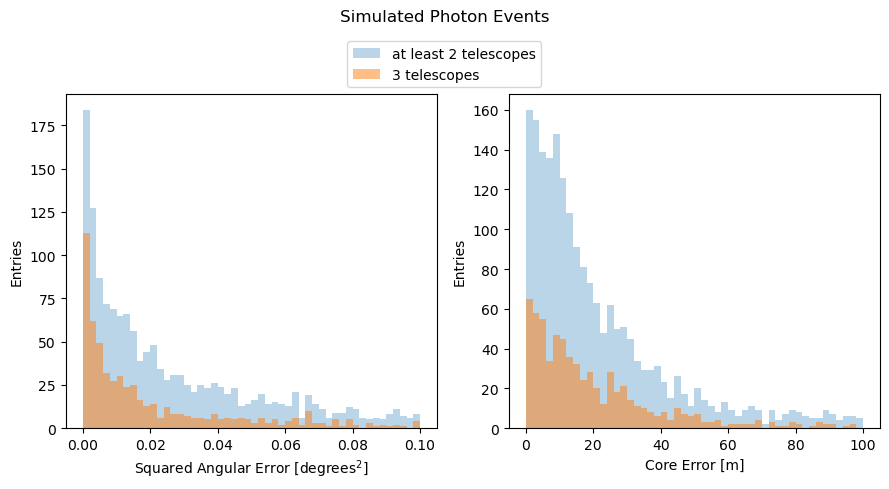

In [7]:
fig, angle1, core1, angle2, core2 = plotPSF(df1, "Simulated Photon Events", (0,0.1),(0,100))

fig.show();

print("====== At least 2 Telescopes ======")
print("Angular Error 68% value: {:.5f} degrees, N={}".format(angle1[0].quantile(0.68), angle1[0].count()))
print("Core Reconstruction 68% value: {:.5f} m, N={}".format(core1[0].quantile(0.68),core1[0].count()))

print("====== 3 Telescopes ======")
print("Angular Error 68% value: {:.5f} degrees, N={}".format(angle2[0].quantile(0.68), angle2[0].count()))
print("Core Reconstruction 68% value: {:.5f} m, N={}".format(core2[0].quantile(0.68),core2[0].count()))

In [8]:
c1 = SkyCoord(az=array1["Az"].values*u.deg, alt=(90-array1["Ze"].values)*u.deg, frame='altaz')
c2 = SkyCoord(az=0*u.deg, alt=90*u.deg,frame='altaz')
angle1=pd.DataFrame(c1.separation(c2).deg)
sqr1=angle1*angle1
array1['ThetaSquare']=sqr1.values

c1 = SkyCoord(az=array2["Az"].values*u.deg, alt=(90-array2["Ze"].values)*u.deg, frame='altaz')
c2 = SkyCoord(az=0*u.deg, alt=90*u.deg,frame='altaz')
angle2=pd.DataFrame(c1.separation(c2).deg)
sqr2=angle2*angle2
array2['ThetaSquare']=sqr2.values

In [9]:
array2.describe()

,Event,Telescope,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,...,Xcore,Ycore,stdP,TrueAz,TrueZe,TrueXcore,TrueYcore,TrueEnergy,MaxDistance,ThetaSquare
count,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,...,694.000000,694.000000,6.940000e+02,694.0,694.0,694.000000,694.000000,694.000000,309.000000,694.000000
mean,51027.854467,1.969741,-0.014576,0.313918,-0.166323,0.321299,168.955082,3914.201729,0.402932,0.216754,...,6.210780,36.547315,8.493143e-01,0.0,0.0,-7.742930,4.805099,106786.114553,4.042428,28.965353
std,28773.411559,0.807937,2.599020,0.135507,2.652793,0.145062,137.037782,6612.134979,0.168006,0.060081,...,253.453792,728.768120,3.953257e+00,0.0,0.0,89.232111,94.232221,144118.733400,1.205805,117.611986
min,25.000000,1.000000,-4.725980,0.078815,-4.754610,0.104579,0.053447,226.000000,0.155344,0.078207,...,-1139.040000,-2806.910000,0.000000e+00,0.0,0.0,-310.311000,-270.712000,10572.000000,0.768588,0.023238
25%,26979.250000,1.000000,-2.078815,0.227660,-2.427653,0.225295,42.346850,900.000000,0.288220,0.169436,...,-67.612000,-71.887500,1.221403e-10,0.0,0.0,-66.936500,-51.398825,29280.600000,3.100160,5.946721
50%,51514.000000,2.000000,-0.089482,0.284446,-0.359200,0.290413,85.748150,1787.000000,0.359256,0.216523,...,-0.945097,-0.567662,3.210180e-09,0.0,0.0,5.821900,9.626180,54216.300000,4.126000,14.560973
75%,73899.000000,3.000000,2.046327,0.375556,2.073367,0.363635,311.261750,3844.500000,0.466342,0.254503,...,59.569800,66.509700,2.040630e-02,0.0,0.0,49.341300,54.582700,112691.000000,4.917610,23.624266
max,99484.000000,3.000000,4.773730,1.110280,4.723380,0.979923,359.262000,51003.000000,1.111330,0.513290,...,2898.200000,12740.400000,3.940270e+01,0.0,0.0,299.964000,346.941000,950843.000000,6.608890,1838.788737


# Quality Factor

$Q=\eta^\gamma/\sqrt{\eta^N}$

In [10]:
gamma_total=array1.Event.nunique()
proton_total=array2.Event.nunique()

In [11]:
def qfactor(gamma,proton):
    num=gamma/gamma_total
    denom=proton/proton_total
    return num/np.sqrt(denom)

# plot

/tmp/ipykernel_1155244/4243486076.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return num/np.sqrt(denom)
/tmp/ipykernel_1155244/4243486076.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return num/np.sqrt(denom)


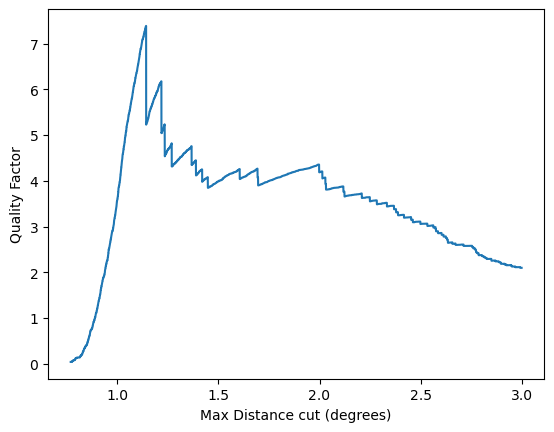

In [12]:
d=np.linspace(0,3,10001)
Q=np.zeros(len(d))

fig,ax = plt.subplots()
plt.xlabel('Max Distance cut (degrees)')
plt.ylabel('Quality Factor')

for i in range(len(d)):
    # max distance cut
    cut1=array1[array1["MaxDistance"].values < d[i]]
    cut2=array2[array2["MaxDistance"].values < d[i]]    

    # theta square cut
    # cut1=cut1[cut1['ThetaSquare'] < 0.32214**2]
    # cut2=cut2[cut2['ThetaSquare'] < 0.32214**2]

    # theta square cut
    # cut1=cut1[cut1['ThetaSquare'] < 0.38**2]
    # cut2=cut2[cut2['ThetaSquare'] < 0.38**2]

    # theta square cut
    # cut1=cut1[cut1['ThetaSquare'] < 0.25**2]
    # cut2=cut2[cut2['ThetaSquare'] < 0.25**2]

    # calc Q factor
    N_gamma=cut1.Event.nunique()
    N_proton=cut2.Event.nunique()

    Q[i]=qfactor(N_gamma,N_proton)

ax.plot(d,Q)



In [13]:
array1.describe()

/home/nkorzoun/Software/miniconda3/envs/panoseti/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Event,Telescope,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,...,Xcore,Ycore,stdP,TrueAz,TrueZe,TrueXcore,TrueYcore,TrueEnergy,MaxDistance,ThetaSquare
count,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5029.000000,5.029000e+03,...,5029.000000,5029.000000,5.029000e+03,5.029000e+03,5029.0,5029.000000,5029.000000,5029.000000,2180.000000,5029.000000
mean,50309.517001,1.939352,-0.016937,0.287757,0.002297,0.282789,183.063587,3539.021277,0.368161,1.844463e-01,...,-54.283273,-51.268560,inf,1.277000e+01,0.0,-6.848639,-0.829278,47422.254882,1.422496,15.129262
std,29058.283095,0.808972,0.963177,0.119777,0.935737,0.120386,138.476960,11489.231243,0.143209,3.924431e-02,...,2068.442986,2044.068849,NaN,3.553067e-15,0.0,90.567474,84.657656,80520.276112,0.572323,264.828006
min,31.000000,1.000000,-3.652490,0.096663,-3.741340,0.117921,0.010616,149.000000,0.152930,7.450580e-09,...,-99999.000000,-99999.000000,0.000000e+00,1.277000e+01,0.0,-319.335000,-435.263000,10013.400000,0.731801,0.000005
25%,24561.000000,1.000000,-0.737296,0.209053,-0.691689,0.205470,44.246200,982.000000,0.270676,1.583670e-01,...,-68.276100,-61.858900,1.024410e-10,1.277000e+01,0.0,-63.764800,-52.314000,14176.600000,1.020947,0.008792
50%,49988.000000,2.000000,-0.096801,0.257197,-0.021447,0.250876,271.302000,1600.000000,0.333965,1.843600e-01,...,-12.444600,-3.416710,2.603890e-09,1.277000e+01,0.0,0.866894,1.626040,22512.500000,1.220815,0.034392
75%,75726.000000,3.000000,0.746171,0.333604,0.722235,0.327693,317.293000,3229.000000,0.422630,2.067440e-01,...,62.805200,72.174000,2.630930e+01,1.277000e+01,0.0,54.953500,52.978700,44577.200000,1.656977,0.138539
max,99999.000000,3.000000,4.323460,0.995592,3.977230,1.046600,360.000000,445408.000000,1.201690,7.407020e-01,...,12284.000000,5214.890000,inf,1.277000e+01,0.0,390.337000,386.184000,985814.000000,4.698700,7935.567091


gamma: 1872
proton: 13


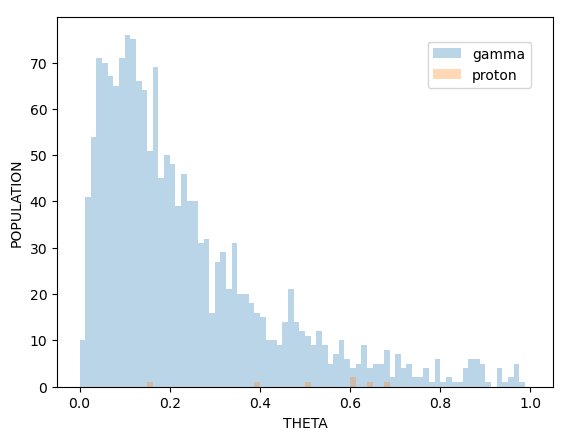

In [14]:
fig, axs = plt.subplots()
plt.xlabel('THETA')
plt.ylabel('POPULATION')

cut1=array1[array1["MaxDistance"].values < 2]
cut2=array2[array2["MaxDistance"].values < 2]   

axs.hist(np.sqrt(cut1.ThetaSquare), alpha=0.3, bins=80, range=(0,1), label='gamma')
axs.hist(np.sqrt(cut2.ThetaSquare), alpha=0.3, bins=80, range=(0,1), label='proton')
fig.legend(loc=(0.75,0.8))

print('gamma:',len(cut1))
print('proton:',len(cut2))

/tmp/ipykernel_1155244/4243486076.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return num/np.sqrt(denom)
/tmp/ipykernel_1155244/4243486076.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return num/np.sqrt(denom)


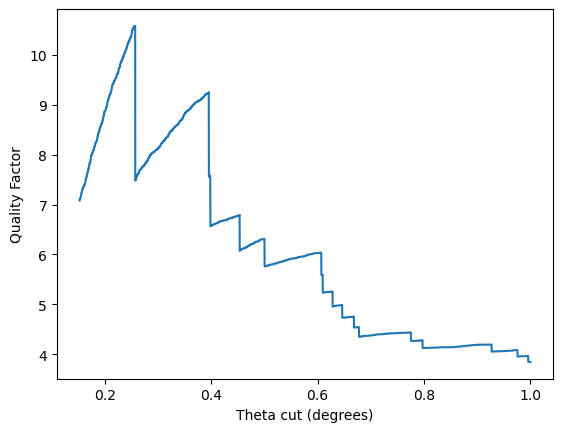

In [15]:
theta=np.linspace(0,1,10001)
Q=np.zeros(len(theta))

fig,ax = plt.subplots()
plt.xlabel('Theta cut (degrees)')
plt.ylabel('Quality Factor')

for i in range(len(theta)):
     # theta square cut
    cut1=array1[array1['ThetaSquare'] < theta[i]**2]
    cut2=array2[array2['ThetaSquare'] < theta[i]**2]

    # # max distance cut
    # cut1=cut1[cut1["MaxDistance"].values < 2.8]
    # cut2=cut2[cut2["MaxDistance"].values < 2.8]    

   
    # calc Q factor
    N_gamma=cut1.Event.nunique()
    N_proton=cut2.Event.nunique()

    Q[i]=qfactor(N_gamma,N_proton)

ax.plot(theta,Q)



gamma: 3535
proton: 5


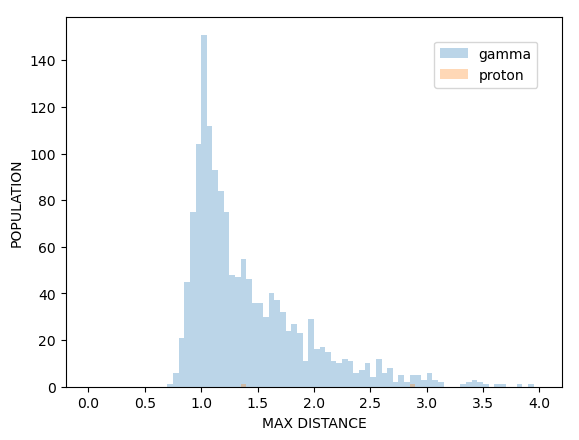

In [16]:
fig, axs = plt.subplots()
plt.xlabel('MAX DISTANCE')
plt.ylabel('POPULATION')

cut1=array1[array1["ThetaSquare"].values < 0.32214**2]
cut2=array2[array2["ThetaSquare"].values < 0.32214**2]   

axs.hist(cut1.MaxDistance, alpha=0.3, bins=80, range=(0,4), label='gamma')
axs.hist(cut2.MaxDistance, alpha=0.3, bins=80, range=(0,4), label='proton')
fig.legend(loc=(0.75,0.8))

print('gamma:',len(cut1))
print('proton:',len(cut2))

In [17]:
# no cuts

N_gamma=array1.Event.nunique()
N_proton=array2.Event.nunique()

print('===========')
print('No cuts:')
print('----------')
print('gamma:',N_gamma)
print('proton:',N_proton)
print('Q factor:', qfactor(N_gamma,N_proton))

No cuts:
----------
gamma: 2180
proton: 309
Q factor: 1.0


In [18]:
# max dist cut
cut1=array1[array1["MaxDistance"].values < 2]
cut2=array2[array2["MaxDistance"].values < 2]  

N_gamma=cut1.Event.nunique()
N_proton=cut2.Event.nunique()

print('===========')
print('Max Distance < 2:')
print('----------')
print('gamma:',N_gamma)
print('proton:',N_proton)
print('Q factor:', qfactor(N_gamma,N_proton))

Max Distance < 2:
----------
gamma: 1872
proton: 13
Q factor: 4.186556092401245


In [19]:
# theta square cut
cut1=array1[array1['ThetaSquare'] < 0.32214**2]
cut2=array2[array2['ThetaSquare'] < 0.32214**2]

N_gamma=cut1.Event.nunique()
N_proton=cut2.Event.nunique()

print('===========')
print('Theta Square cut:')
print('----------')
print('gamma:',N_gamma)
print('proton:',N_proton)
print('Q factor:', qfactor(N_gamma,N_proton))

Theta Square cut:
----------
gamma: 1481
proton: 2
Q factor: 8.44428352614019


In [20]:
# Both
cut1=array1[array1["MaxDistance"].values < 2]
cut2=array2[array2["MaxDistance"].values < 2]  

cut1=cut1[cut1['ThetaSquare'] < 0.32214**2]
cut2=cut2[cut2['ThetaSquare'] < 0.32214**2]

N_gamma=cut1.Event.nunique()
N_proton=cut2.Event.nunique()

print('===========')
print('Both Cuts:')
print('----------')
print('gamma:',N_gamma)
print('proton:',N_proton)
print('Q factor:', qfactor(N_gamma,N_proton))

Both Cuts:
----------
gamma: 1288
proton: 1
Q factor: 10.385767812222968


keeps 60% gammas, rejects 99.9% protons